## Welcome to the third mini-lecture!

Now that we have some sense of what the derivative tells us about the function, for how to do backpropagation manually, and now that we also have our Value class partially built out, let's begin this lecture with by backpropogating through a neuron (which we will eventually use to build out neural networks). Run the code until you get to the next text block.

In [106]:
!pip install graphviz
!export PATH="/usr/local/opt/graphviz/bin:$PATH"


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [107]:
from graphviz import Digraph #graphviz is an opensource vizualization software. We are building out this graph in graphviz API. 

def trace(root): #helper function that enumerates the ndoes and edges in the graph
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root): #creating op nodes (not Value objects)
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root) #call trace
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad % .4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it. Not a value object
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### One more example of backpropogation...

We want to backpropogate through a neuron. In the simplest case, a neural network is made up of layers of neurons with an input layer, intermediate layers, and an output layer. These are called **Multi-Layer Perceptrons**. We can also mathmatically model the neurons we will use to contain the data and gradients for each variable in our neural netowrk. Observe the two pictures below:

Two Layer Neural Network:
![mlp](/images/mlp.jpeg)

Neuron:
![neuron](/images/neuron_model.jpeg)

In the neuron, we have inputs ($x$), and the synapses that have weights on them. The $w's$ are weights. The synapse enacts with the input to the neuron multiplicatively. What flows to the cell body of the neuron is $w*x$. There are many of these inputs flowing into the cell body. The cell body also has bias, $b$, which indicates the trigger-happiness of the neuron. 

Basically, we take all of the $w*x$ of the inputs, add it to the bias, and put it into the activation function.

- ```x0, x1, x2``` = axen from a neuron
- ```w0, w1, w2``` = weights
- ```synapse``` = w0x0. Many synapses (```w1x1, $w2x2```)
- ```synapse``` travels on a dendrite to the cell body
- cell body contains the sum of the inputs plus a ```bias``` (which dictates the trigger happiness of the synapse/neuron -> bit more or bit less trigger-happy regardless of input)
- taking all of the ```wx``` of all the inputs + bias (```i``` iterations), taking it through an activation function (```sigmoid```, ```tanh```, etc.)

The python ```numpy``` library has a ```tanh```, ```np.tanh```. We will use this in the example, and call it on a range and plot it:

In [108]:
import matplotlib.pyplot as plt
import numpy as np

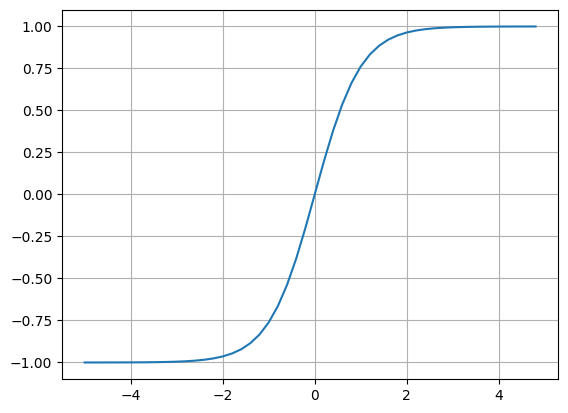

In [109]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();
#called on a range from -5 to 5 with a slope of -2.

- Inputs as they come in get squashed on the y coordinate, only goes up to 1 and then plateaus. 
- We cap it smoothly to 1 and -1. This is this is an activation (squashing) function. 
- What comes out of this neuron is the activation applied to the dot product of the weights and the inputs (see cell image)

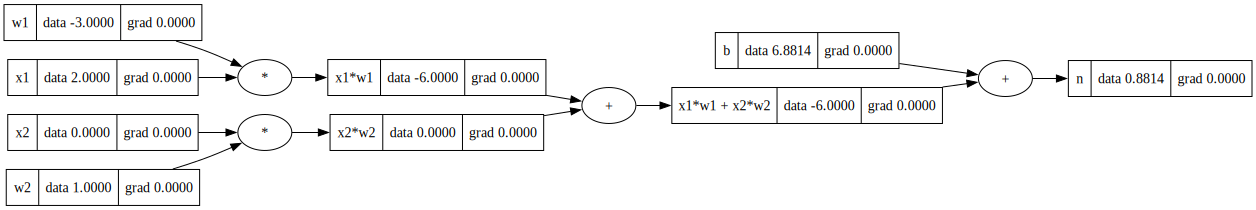

In [110]:
# inputs x1,x2; two dimensional neuron (two weights come in)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2; the synaptec strengths of each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron b
b = Value(6.8813735870195432, label='b')

#according to the model above, we multiply x1 * w1 and x2 * w2 + b. 
# x1*w1 + x2*w2 + b; doing it in small steps so we have pointers to the intermediate steps
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

#n is now the cell body raw activation sum without the raw activation function
n = x1w1x2w2 + b; n.label = 'n' 
draw_dot(n)

Now, we're going to take it through activation function tanh to get the output.

In [111]:
import math

In [112]:
# inputs x1,x2; two dimensional neuron (two weights come in)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'


#o = n.tanh(); o.label = 'o'

#draw_dot(o)

#output would be  an error because we haven't written the tanh activation function yet. Implement this tanh function because tanh is a hyperbolic function,
#and we only have so far implemented an addition function and a multiplication function. We can't make a tanh 
#out of just addition and multiplication; we need to add in exponentiation and division functionalities

Here is the hyperbolic tangent function we will use for the activation:

$$tanh(x)={\frac {\sinh x}{\cosh x}}={\frac {e^{x}-e^{-x}}{e^{x}+e^{-x}}}={\frac {e^{2x}-1}{e^{2x}+1}}$$

More on this is available at: https://en.wikipedia.org/wiki/Hyperbolic_functions

Now let's implement ```tanh()``` in the ```Value``` class. Since we don't necessarily need the most atomic pieces for this function, we can create functions at arbitrary points of abstraction. The only thing that matters is that we know how to differentiate (create the local derivative (how the inputs impact the output)), that's all you need.

We could create a ```exp(self)``` function. The line of thinking for this would be that we already have addition and multiplication, so all we would need to do is make an exponent function and then use them all in conjunction with each other for the hyperbolic tangent formula above. But since the above is true, we will directly implement ```tanh()``` instead of breaking it up into its atomic pieces. 

Notice the ```tanh()``` implementation in the Value class:


In [113]:
class Value:
    
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
      
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out
      
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

  #def exp(self):
    #one option is to implement this exp function for the tanh, because this is the only thing we need for tanh besides add and multiply.

  def tanh(self):
      x = self.data
      t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
      
      #children of node, one output. Self is a tuple:
      out = Value(t, (self, ), 'tanh')
      return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')  #added labels
e = a*b; e.label = 'e'      #added e for a * b
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; label = 'L'
L

Value(data=-8.0)

Now, we should be able to do ```n.tanh()```:

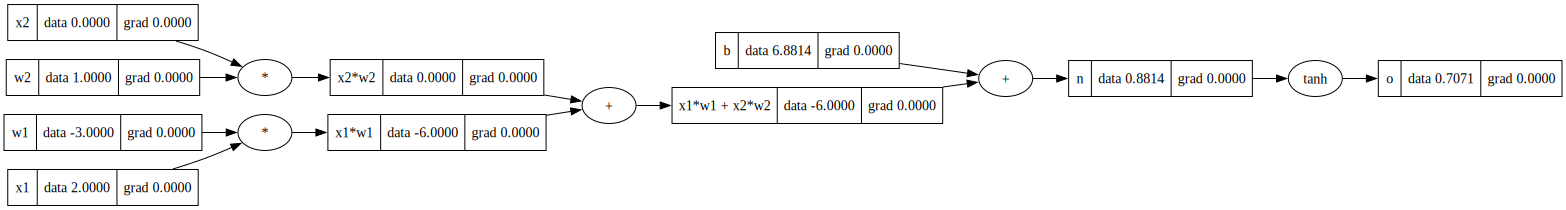

In [114]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b') #weird number used for nice output... try with b = Value(8.0)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'   #we've now implemented tanh(). As long as we know the derivative of tanh, we can backprop through it.
#let's visualize it. tanh is squashing our output n to a value between -1 and 1:
draw_dot(o)

What is the derivative of ```o``` with respect to all of the inputs?

We care about the derivative of the weights of the neurons specifically ($w2$ and $w1$), because that's what we'll be changing for all the neurons in the optimization.

Eventually there's a loss function we'll use that measures the accuracy of the neural net, which we'll try to improve with backpropogration.

Let's start with backprop at the end. What is the derivative of ```o``` with respect to ```o``` (the base case)? It's always $1.0$


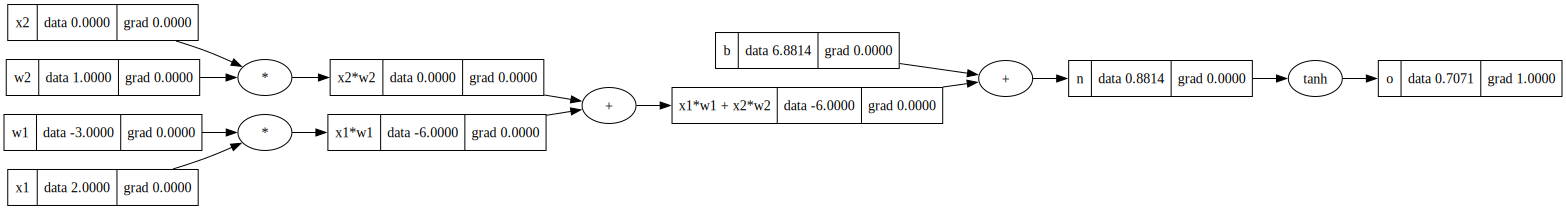

In [115]:
o.grad = 1.0
#now, we see o.grad is 1
draw_dot(o)

Now, we backprop through ```tanh()```. To do this, we need the derivative of ```tanh()```.
If we go back to the wiki site and find the derivative function for this:
https://en.wikipedia.org/wiki/Hyperbolic_functions

Then, in the third row of derivatives, we are greeted with:

$${\frac{d}{dx}tanh(x)={1- {tanh}^2(x)}}$$


In [116]:
#o = tanh(n)
#what is do/dn? -> the above is saying that:
#do/dn = 1 - o**2
1 - o.data**2 # this means the local derivative of the tanh() operation is 0.5. We set it and redraw:

0.4999999999999999

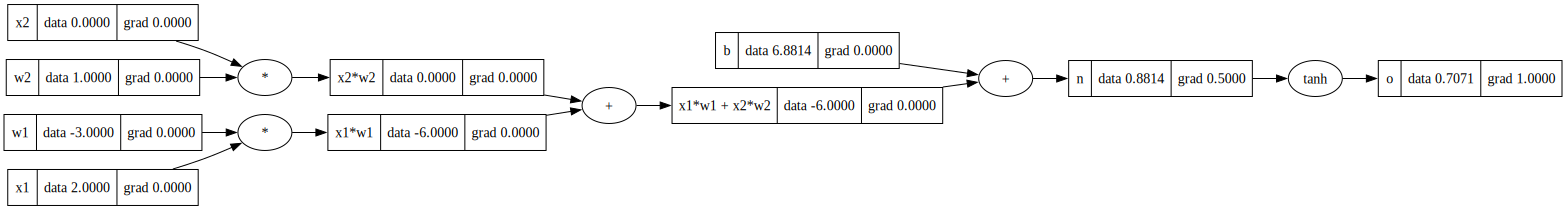

In [117]:
n.grad = 0.5
draw_dot(o)

Let's continue with backpropogation from $n$ to $b + x1w1 + x2w2$. 

Remember that a $+$ operator is an even distributor of the gradient in backpropogation. The gradient flows to $b$ and $x$ evenly, so we will set those below. Then, we meet another $+$ operator that adds $x2w2$ and $x1w1$. This will also distribute $x1w1+x2w2$ evenly.

We set them and redraw:

In [118]:
x1w1x2w2.grad = 0.5
b.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5

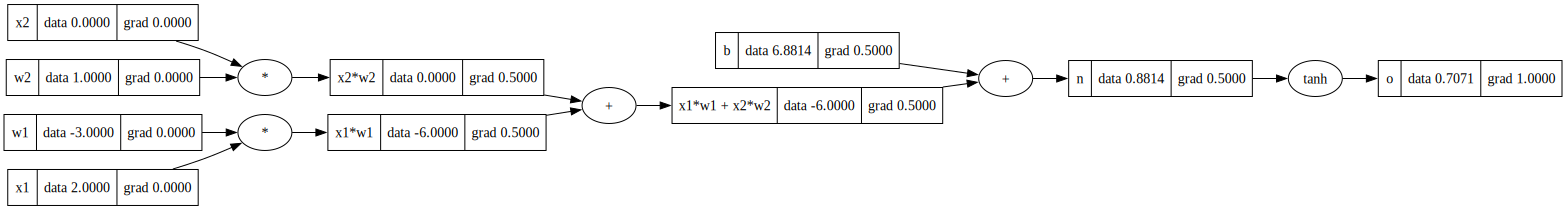

In [119]:
draw_dot(o)

Now, we have $0.5$ flowing into the final multiplication operations. If we want to calculate ```x2.grad```, it will be ```x2.grad = w2.data * x2w2.grad```. Then, ```w2.grad = x2.data * x2w2.grad```. This is this the chain rule (refer back to the de/da example in the second lecture if help is needed)

In [122]:
#derivative always tells us the influence of data on the final output.
#if we want the output of this neuron to increase, the influence of these expressions on the output is positive.

#If I wiggle w2, how is the output changing? it's not, because it's getting multiplied by 0 (grad = 0). Because it's not changing,
#there is no derivative, thus w2 grad = 0.

#the local derivative of * with respect to x1 is w1. 
x1.grad = w1.data * x1w1.grad 
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

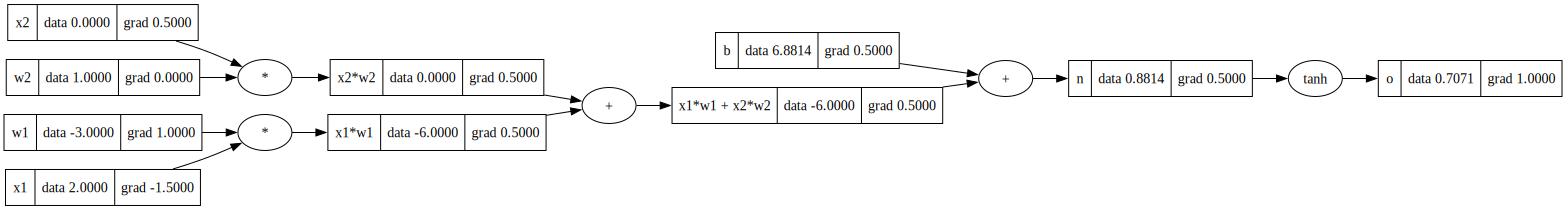

In [123]:
draw_dot(o)

Now, we will see how we can equip the backward pass automatically instead of manually! We revisit the Value object and making ```backward()``` functions that will do the chain rule at each local node. It will chain the output gradient into the input gradients. We will not implement this in the constructor, but rather in the ```__add__```, ```__mul__```, and ```tanh()``` functions themselves. Read the comments for explanations, and then reinitialize the Value class by running it again.

In [179]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''): 
    self.data = data
    self.grad = 0.0 
    self._prev = set(_children)
    self.backward = lambda : None
      #^fucntion that does piece of chain rule at each little node that took inputs and produced outputs, store 
      #how we are going to chain the output gradient into the input gradients
      #by default it doesn't do anything -> this way for a leaf node there's nothing to do. But, we will implement it in the other functions.
    self._op = _op
    self.label=label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
      out = Value(self.data + other.data, (self, other), '+') #feed in children of the value
      
     #out.grad will be propogated into self.grad and others.grad for addition
      def _backward():          
          self.grad += 1.0 * out.grad    #addition -> local derivative of self * the global derivative
          other.grad += 1.0 * out.grad   #addition chain rule
          
      out._backward = _backward #don't call the function like out._backward = _backward(), because that returns none -> just store/save it
      return out
      
  def __mul__(self, other):
      out = Value(self.data * other.data, (self, other), '*')

      def _backward():
          self.grad = other.data * out.grad    #local derivative * out.grad(global derivative)
          other.grad = self.data * out.grad    
      out._backward = _backward
      return out
    
  def tanh(self):
      x = self.data
      t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
      
      out = Value(t, (self, ), 'tanh')

      def _backward():
          #we have out.grad, we want to chain it into self.grad
          #self.grad will be the local derivative of this operation above (tanh).
          #The gradient has to be multiplied because of the chain rule; out.grad is chained through the local grad into self.grad
          #1-tanh(x**2) -> 
          #1 - t^2 is the local derivative (t is tanh).
          self.grad = (1-t**2) * out.grad
      out._backward = _backward
      return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

Now, we reinitialize the variables for our neural net:

In [180]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b') #weird number used for nice output... try with b = Value(8.0)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

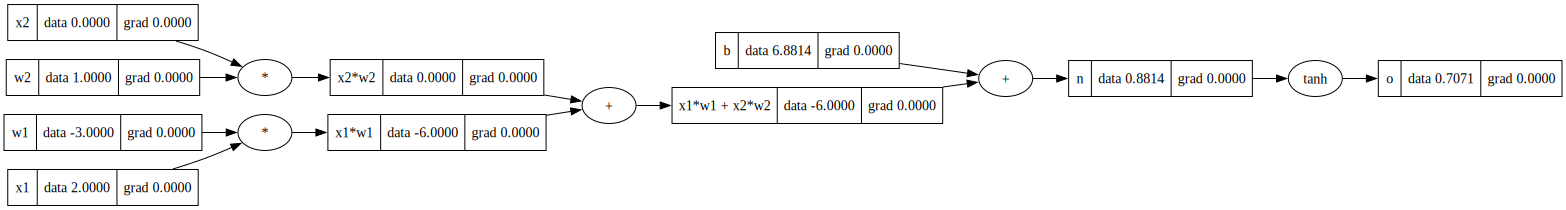

In [181]:
draw_dot(o)   #make sure all the grads are 0 again

Great! Now, we don't have to do the backward part manually anymore (i.e., ```x1.grad = w1.data * x1w1.grad```, etc.

We initialize ```o.grad``` to 1 below because the default constructor initializes it to 0.0, which will cause self.grad to be 0 in the 
```backward()``` ```tanh()``` function. 

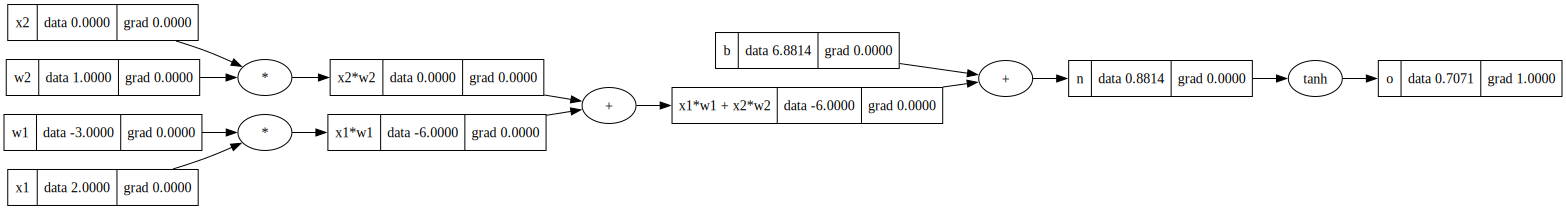

In [182]:
o.grad = 1.0
draw_dot(o)

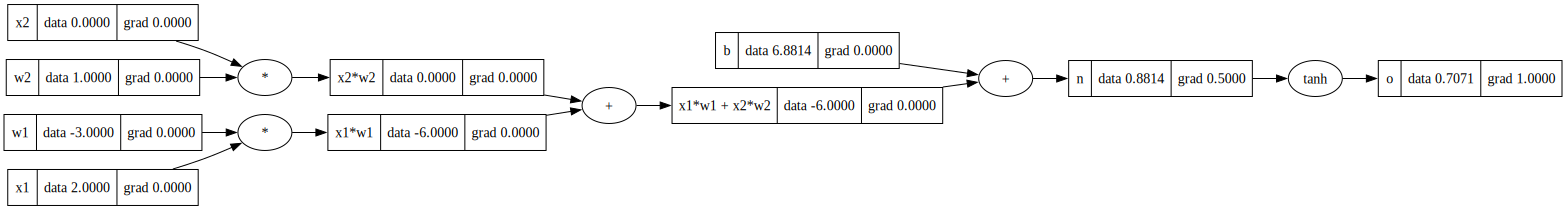

In [183]:
o._backward() #will propogate the o.grad through tanh(). The global derivative (init to 1) multiplied by the local derivative
draw_dot(o) #n.grad should be 0.5

Now, run the following and observe the changes in draw_dot(o) by re-running it after each block:

In [186]:
n._backward() #spreads gradient to both children (+)

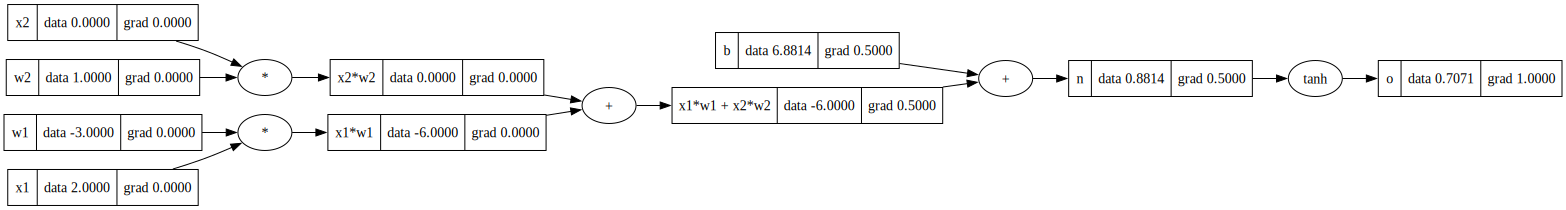

In [187]:
draw_dot(o)

In [188]:
b.backward() #b doesn't have a backward, because it's a leaf node. By init, it's the empty function

In [189]:
x1w1x2w2._backward() #0.5 is routed

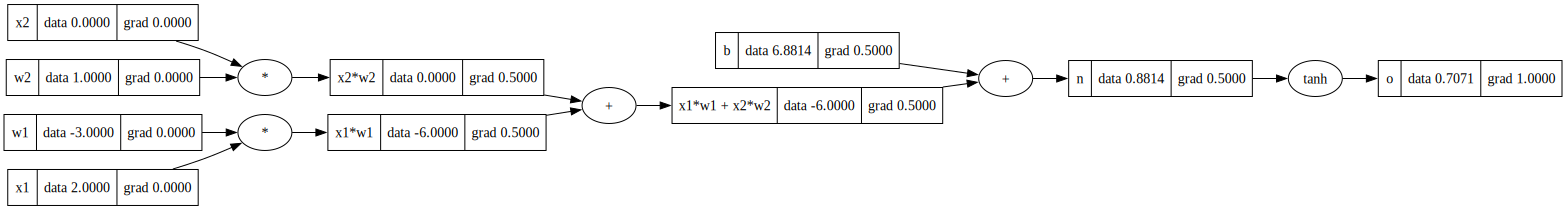

In [190]:
draw_dot(o)

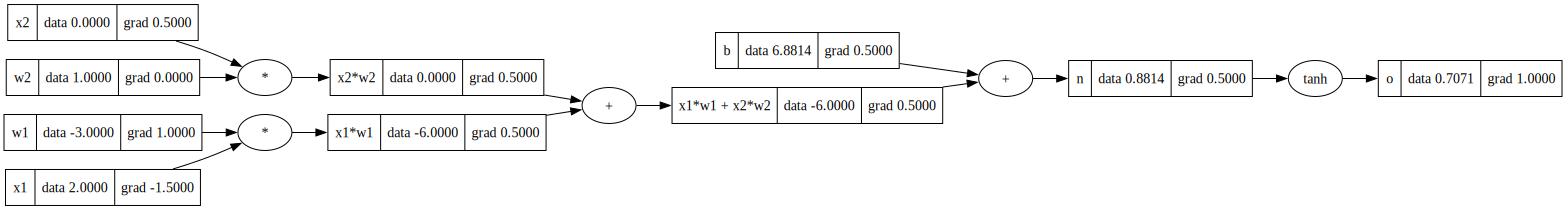

In [191]:
x2w2._backward()
x1w1._backward()
draw_dot(o)

### Now we get rid of one more inefficiency... calling ._backward() manually

We layed out a math expresssion, trying to go backwards thru expressiosn. Never want to call a .back for any node before we've done everything after it. We have to get all of its full dependencies, they have to propogate through it before we use it. 

We can do this through a topological sort, where we make a graph that has all of its edges layed out from left to right. Wikipedia says it's: "a linear ordering of its vertices such that for every directed edge (u,v) from vertex u to vertex v, u comes before v in the ordering."

In [397]:
L.grad = 1.0
#F.GRAD is the value of d, d.grad is the value of f
f.grad = 4.0
d.grad = -2.0

In [ ]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''): 
    self.data = data
    self.grad = 0.0 
    self._prev = set(_children)
    self.backward = lambda : None
      #^fucntion that does piece of chain rule at each little node that took inputs and produced outputs, store 
      #how we are going to chain the output gradient into the input gradients
      #by default it doesn't do anything -> this way for a leaf node there's nothing to do. But, we will implement it in the other functions.
    self._op = _op
    self.label=label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
      out = Value(self.data + other.data, (self, other), '+') #feed in children of the value
      print("out ", out)
#on the bottom example, out is b (= a+a).
#problem is we're setting the gradient (self and other are the same) twice.
      
      def _backward():           #chain rule: take local derivative x the global derivative (of final output of exp) with respect to out
          self.grad += 1.0 * out.grad    #addition
          print("self.grad = ", self.grad)
          other.grad += 1.0 * out.grad      #out.grad will be copied into self.grad and others.grad for addition
          print("other.grad = ", other.grad)
      out._backward = _backward
      return out
  def __mul__(self, other):
      out = Value(self.data * other.data, (self, other), '*')

      def _backward():
          self.grad = other.data * out.grad    #local derivative * out.grad
          other.grad = self.data * out.grad
      out._backward = _backward
      return out
      
  #def exp(self):
    #one option is to implement this exp function for the tanh, because this is the only thing we need for tanh besides add and multiply.

  def tanh(self):
      x = self.data
      t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
      
#children of node, one output. Self is a tuple:
      out = Value(t, (self, ), 'tanh')

      def _backward():
          #we have out.grad, we want to chain it into self.grad
          #self.grad will be the local der of this operation above (tanh), gradient has to be multiplied -> 
          #chain rule; outgrad is chained through the local grad into self.grad
#1-tanh(x**2) -> 1-t**2 is local der
          self.grad = (1-t**2) * out.grad
      out._backward = _backward
      return out

def backward(self):
    o.grad = 1.0 #init set to 0

    topo = []
    visited = set()
    def build_topo(v):   #start at root node, for us is o
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()
#o only adds itself to topo list after all of the children have been processed
#just calling ._backward to all of the topological nodes in order

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e=a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

#python internally calls a.__add__(b). b is other, and self is a
#a * b + c  #a.__mul__(b)).__add__(c)

In [105]:
def dummyFunction():
    h = 0.0001 #small a mount to add

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    #a.data += h -> a.grad is 6
    b = Value(-3.0, label='b')
    #b.data += h -> -4
    c = Value(10.0, label='c')
    #c.data += h 
                                #when we do  c.data += h, we expect to see -2 because of the chain rule -> dL/dc = -2.0(dd) * 1 (dc)
    e= a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')  #inline gradient check: deriving backpropogation getting 
                                    #deriviative with respect to all intermediate results
                                    #Numerical gradient is estimating it using small step size
    L = d * f; L.label = 'L'
    L2 = L.data 

    print((L2 - L1)/h)



#when testing derivatives, ply in + h to any of the value objects in L2. For example, if finding der of L with respect to f,
#add h to -2.0 in f's value object. Since the derivative of 
dummyFunction()

6.000000000021544


In [408]:
x1w1._backward()
x2w2._backward()

Now, we get the same thing, but doing it through code. Not manually. 
We have to forward pass through everything after it and backprop through everything before it before we backprop a given node
Look at topological sort -> lays out nodes so that all edges go one way (left-> right). Let's implement

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

calling add
out  Value(data=6.0)
self.grad =  0.0
other.grad =  0.0


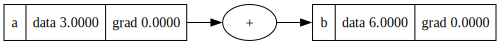

In [424]:
a = Value(3.0, label='a')
b = a + a    ; b.label = 'b'
b._backward()
draw_dot(b)
#two arrows on top of each other. forward pass works. Gradient not correct
#the derivative with respec to a should be 2, 1+1.

calling add
out  Value(data=1.0)


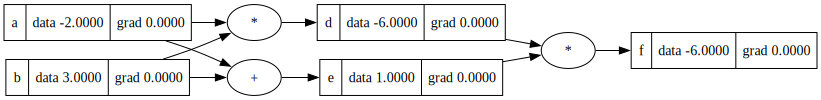

In [427]:
a = Value(-2.0, label='a')
b = Value(3.0, label= 'b')
d = a * b     ; d.label = 'd'
e = a + b     ; e.label = 'e'
f = d * e     ; f.label = 'f'

f.backward()

draw_dot(f)

#look at the multivariable case of the chain rule -> solution: accumulate gradients. Instead of setting gradients, simply do +=. Deposit
#gradients from each branch, even if the same var. And then they add on top of each other. 